In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from stargazer.stargazer import Stargazer

# Import data

In [2]:
file = 'PS_7_Buffetts_exercise.xlsx'

In [3]:
# import factors
factors = pd.read_excel(file, sheet_name='factors', parse_dates=["date"], index_col='date')
factors.head()

,RF,Mkt-RF,SMB,HML,QMJ,BAB,UMD
date,,,,,,,
1976-10-29,0.0041,-0.0242,0.0025,-0.0013,0.000291,0.009824,-0.0048
1976-11-30,0.0040,0.0036,0.0232,0.0151,-0.020044,0.003814,0.0290
1976-12-31,0.0040,0.0565,0.0301,0.0222,-0.006284,0.032671,0.0077
1977-01-31,0.0036,-0.0405,0.0478,0.0426,-0.020399,0.038325,0.0398
1977-02-28,0.0035,-0.0195,0.0109,0.0050,0.016226,0.028703,0.0038


In [4]:
# import returns
data = pd.read_excel(file, sheet_name='buffet_data', parse_dates=["date"], index_col='date')
data.head()

,"Berkshire Hathaway, total return","Public stocks from 13F, total return","Heinz, total return","Kraft, total return"
date,,,,
1976-10-29,NaN,NaN,NaN,NaN
1976-11-30,0.154412,NaN,0.044643,NaN
1976-12-31,0.146497,NaN,0.158803,NaN
1977-01-31,0.000000,NaN,-0.052045,NaN
1977-02-28,0.000000,NaN,0.027451,NaN


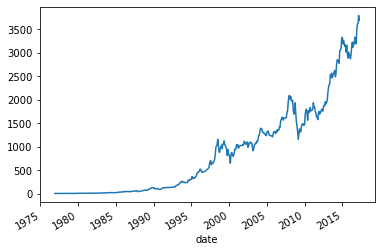

In [5]:
# plot the cum return of Berkshire
(1 + data.loc[:, "Berkshire Hathaway, total return"].dropna()).cumprod().plot();

In [6]:
def analyze_performance(monthly_returns):
    # monthly performance 
    avg = monthly_returns.mean()
    sd = monthly_returns.std()
    sr = avg / sd
    #annualized performance
    avg_ann = avg * 12
    sd_ann = sd * np.sqrt(12)
    sr_ann = avg_ann / sd_ann
    # format in percent
    avg, avg_ann = str(round(avg * 100, 2)) + "%", str(round(avg_ann * 100, 2)) + "%"
    sd, sd_ann = str(round(sd * 100, 2)) + "%", str(round(sd_ann * 100, 2)) + "%"
    # create output
    stats = pd.DataFrame([[avg, sd, round(sr, 2)],
                          [avg_ann, sd_ann, round(sr_ann, 2)]],
                        columns=["Mean", "Std", "SR"],
                        index=["Monthly", "Annual"])  
    
    return stats

In [7]:
xrets_berk = data.loc[:, "Berkshire Hathaway, total return"].dropna() - factors.loc[:, "RF"]

In [8]:
analyze_performance(xrets_berk)

,Mean,Std,SR
Monthly,1.55%,6.8%,0.23
Annual,18.62%,23.56%,0.79


In [9]:
#beta
y = xrets_berk.dropna()
x = factors.loc[:, "Mkt-RF"].reindex(y.index)
regression = sm.OLS(y , sm.add_constant(x)).fit()
alpha = regression.params.loc["const"] * 12
beta = regression.params.loc["Mkt-RF"]
ssr = regression.ssr
print("Beta:", round(beta, 2))

Beta: 0.69


In [10]:
y

date
1976-11-30    0.150412
1976-12-31    0.142497
1977-01-31   -0.003600
1977-02-28   -0.003500
1977-03-31    0.073978
                ...   
2016-11-30    0.094643
2016-12-30    0.032429
2017-01-31    0.006956
2017-02-28    0.044359
2017-03-31   -0.028209
Length: 485, dtype: float64

In [11]:
# information ratio
ir = alpha / np.sqrt(ssr / len(xrets_berk.dropna()) * 12)
round(ir, 2) 

0.64

# Regression

In [12]:
def time_series_regressions(y, x):
    
    # 1-factor market model
    x_1 = x.loc[:, "Mkt-RF"]
    model_1 = sm.OLS(y, sm.add_constant(x_1), missing="drop").fit()
    
    # Fama-French 3-factor model
    x_2 = x.loc[:, ["Mkt-RF", "SMB", "HML"]]
    model_2 = sm.OLS(y, sm.add_constant(x_2), missing="drop").fit()
    
    # FF 3-factor model augmented with BAB and QMJ
    x_3 = x.loc[:, ["Mkt-RF", "SMB", "HML", "BAB", "QMJ"]]
    model_3 = sm.OLS(y, sm.add_constant(x_3), missing="drop").fit()
    
    return [model_1, model_2, model_3]

In [13]:
# compute excess returns
BRK = data.loc[:, "Berkshire Hathaway, total return"] - factors.loc[:, "RF"]
BRK = BRK.rename("Berkshire Hathaway, excess return")

In [14]:
# run the regressions
models = time_series_regressions(BRK, factors)

# compute annaulized alpha of each model using list comprehension
alphas = [round(model.params.loc["const"] * 100 * 12, 2) for model in models]

In [15]:
# present regression results
stargazer = Stargazer(models)
stargazer.add_line("Annualized Alpha (in %)", alphas)
stargazer.covariate_order(["const", "Mkt-RF", "SMB", "HML", "BAB", "QMJ"])
stargazer

# Berkshire performance II

In [16]:
# compute excess returns
PS = data.loc[:, "Public stocks from 13F, total return"] - factors.loc[:, "RF"]
PS = PS.rename("Public stocks from 13F, excess return")

In [17]:
# run the regressions
models = time_series_regressions(PS, factors)

# compute annaulized alpha of each model using list comprehension
alphas = [round(model.params.loc["const"] * 100 * 12, 2) for model in models]

In [18]:
# present regression results
stargazer = Stargazer(models)
stargazer.add_line("Annualized Alpha (in %)", alphas)
stargazer.covariate_order(["const", "Mkt-RF", "SMB", "HML", "BAB", "QMJ"])
stargazer

# Berkshire performance III

In [19]:
# put both time-series of excess returns into a single DataFrame
xrets = pd.concat([BRK, PS], axis=1)

In [20]:
# remove all rows which contain missing values
xrets = xrets.dropna()
xrets

,"Berkshire Hathaway, excess return","Public stocks from 13F, excess return"
date,,
1980-04-30,0.061474,0.055592
1980-05-30,0.129831,0.084365
1980-06-30,-0.066706,0.032121
1980-07-31,0.123732,0.072282
1980-08-29,0.093600,0.034991
...,...,...
2016-11-30,0.094643,0.035123
2016-12-30,0.032429,0.036866
2017-01-31,0.006956,0.020625


In [25]:
avg = xrets.mean() * 12
round(avg * 100, 2)

Berkshire Hathaway, excess return        16.74
Public stocks from 13F, excess return    12.03
dtype: float64

In [28]:
sd = xrets.std() * np.sqrt(12)
round(sd * 100, 2)

Berkshire Hathaway, excess return        22.30
Public stocks from 13F, excess return    16.25
dtype: float64

In [29]:
sr = avg / sd
round(sr, 2)

Berkshire Hathaway, excess return        0.75
Public stocks from 13F, excess return    0.74
dtype: float64